# **Customer Segmentation with k-Means Clustering and PCA**


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Reproducibility
RANDOM_STATE = 24053142
np.random.seed(RANDOM_STATE)

# Plot style
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True
sns.set(style="whitegrid")


## **1. Data Loading and Initial Inspection**

We use the **Mall Customers** dataset, which contains basic demographic and spending information about customers visiting a shopping mall.

Typical features include:

- `CustomerID`
- `Gender`
- `Age`
- `Annual Income (k$)`
- `Spending Score (1-100)`

Download the CSV (e.g. `Mall_Customers.csv`) and place it in the same directory as this notebook.

Dataset Link: https://www.kaggle.com/datasets/shwetabh123/mall-customers?resource=download

In [13]:
# Adjust the path if your CSV is in a different folder
data_path = "Mall_Customers.csv"

df = pd.read_csv(data_path)
print("Shape:", df.shape)
df.head()

Shape: (200, 5)


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [15]:
df.describe(include="all")

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


### **1.1 Quick EDA**

Before clustering, we want to understand the marginal distributions of key variables:

- Age distribution
- Annual Income distribution
- Spending Score distribution

We also briefly inspect the gender balance.


/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


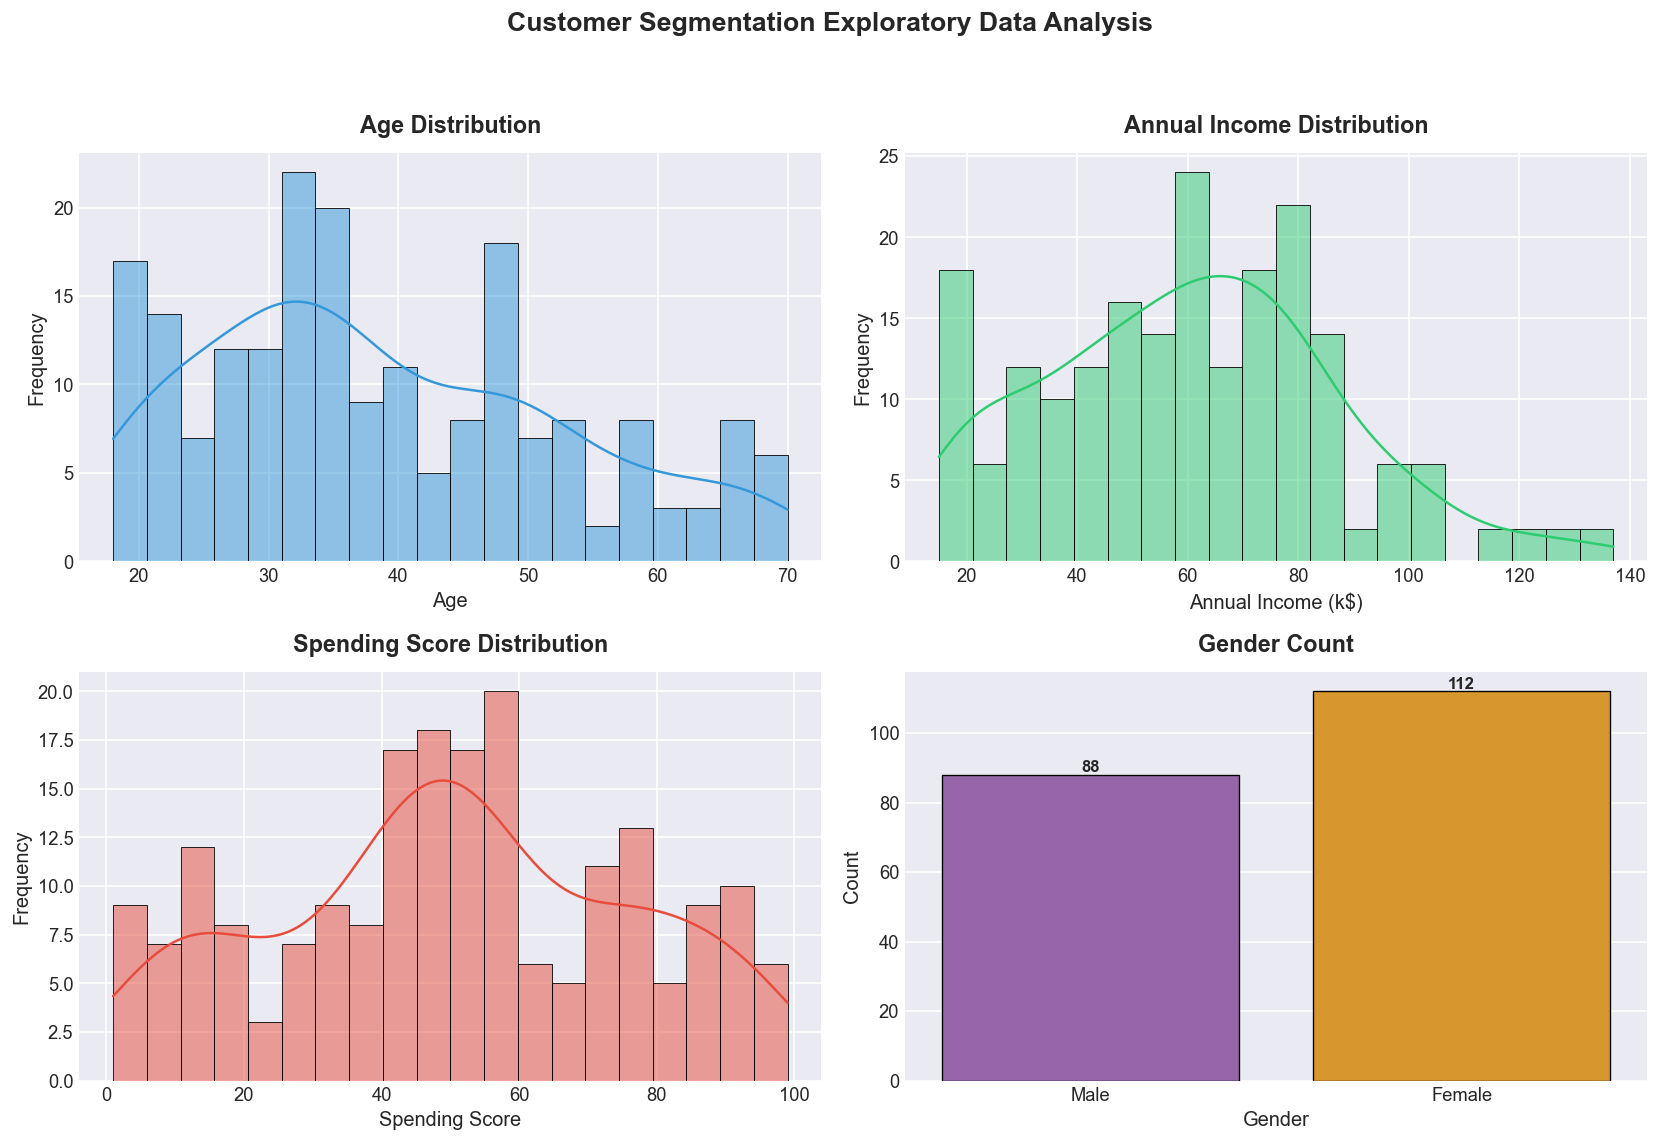

In [20]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=120)

# Age distribution
sns.histplot(
    data=df,
    x="Age",
    kde=True,
    bins=20,
    color='#3498db',
    edgecolor='black',
    linewidth=0.5,
    ax=axes[0, 0]
)
axes[0, 0].set_title("Age Distribution", fontsize=14, weight='bold', pad=12)
axes[0, 0].set_xlabel("Age", fontsize=12)
axes[0, 0].set_ylabel("Frequency", fontsize=12)

# Annual Income
sns.histplot(
    data=df,
    x="Annual Income (k$)",
    kde=True,
    bins=20,
    color='#2ecc71',
    edgecolor='black',
    linewidth=0.5,
    ax=axes[0, 1]
)
axes[0, 1].set_title("Annual Income Distribution", fontsize=14, weight='bold', pad=12)
axes[0, 1].set_xlabel("Annual Income (k$)", fontsize=12)
axes[0, 1].set_ylabel("Frequency", fontsize=12)

# Spending Score
sns.histplot(
    data=df,
    x="Spending Score (1-100)",
    kde=True,
    bins=20,
    color='#e74c3c',
    edgecolor='black',
    linewidth=0.5,
    ax=axes[1, 0]
)
axes[1, 0].set_title("Spending Score Distribution", fontsize=14, weight='bold', pad=12)
axes[1, 0].set_xlabel("Spending Score", fontsize=12)
axes[1, 0].set_ylabel("Frequency", fontsize=12)

# Gender count
sns.countplot(
    x="Genre",
    data=df,
    palette=['#9b59b6', '#f39c12'],
    edgecolor='black',
    linewidth=0.8,
    ax=axes[1, 1]
)
axes[1, 1].set_title("Gender Count", fontsize=14, weight='bold', pad=12)
axes[1, 1].set_xlabel("Gender", fontsize=12)
axes[1, 1].set_ylabel("Count", fontsize=12)

# Add value labels on bars
for p in axes[1, 1].patches:
    axes[1, 1].annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        fontsize=10,
        weight='bold'
    )

plt.suptitle("Customer Segmentation Exploratory Data Analysis", fontsize=16, weight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 2. **Feature Selection and Preprocessing**

k-means clustering operates in a Euclidean feature space. We therefore:

1. Select a subset of meaningful numerical features for customer segmentation.
2. Standardise them so that each feature contributes comparably to Euclidean distances.

A standard choice for this dataset is:

- `Age`
- `Annual Income (k$)`
- `Spending Score (1-100)`

These capture demographic and behavioural aspects relevant to marketing decisions.


In [21]:
features = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]
X = df[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]


array([[-1.42456879, -1.73899919, -0.43480148],
       [-1.28103541, -1.73899919,  1.19570407],
       [-1.3528021 , -1.70082976, -1.71591298],
       [-1.13750203, -1.70082976,  1.04041783],
       [-0.56336851, -1.66266033, -0.39597992]])

## **3. k-Means Clustering: Algorithm and Intuition**

The **k-means algorithm** partitions data into \( K \) clusters by minimising the **within-cluster sum of squared distances**:




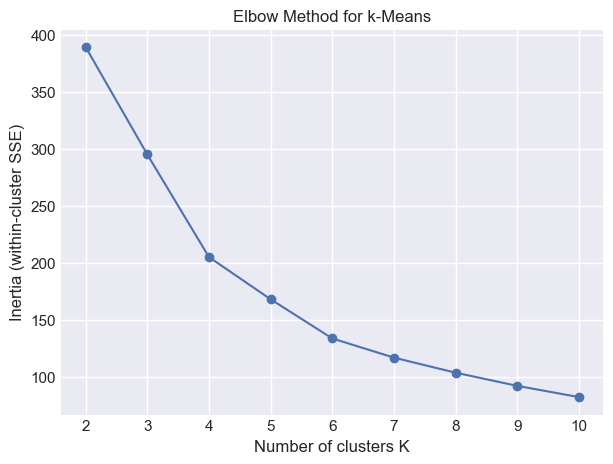

In [22]:
inertias = []
K_range = range(2, 11)  # try K from 2 to 10

for k in K_range:
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=10,
        max_iter=300,
        random_state=RANDOM_STATE
    )
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(list(K_range), inertias, marker="o")
plt.xlabel("Number of clusters K")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow Method for k-Means")
plt.xticks(list(K_range))
plt.show()


### 3.1 Interpreting the Elbow Plot

The inertia (sum of squared distances to the closest centroid) always decreases as K increases, but with diminishing returns.  

We look for a value of K where the inertia curve bends – the **"elbow"**. In the Mall Customers dataset, the elbow is often around **K = 4 or 5**, suggesting a small number of interpretable customer segments.

However, the elbow method is partly subjective. To complement it, we compute the **silhouette coefficient** for different values of K.


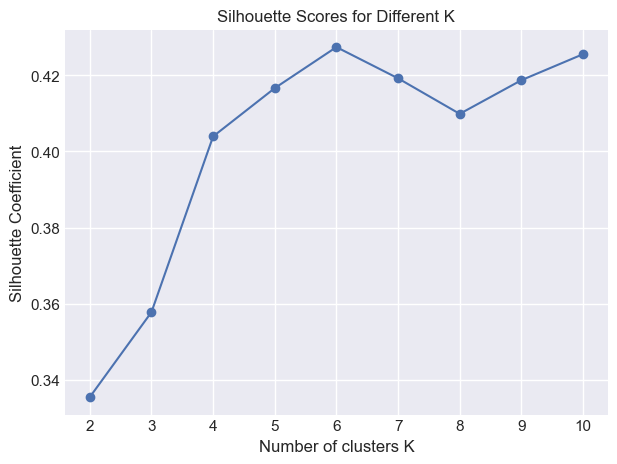

[(2, 0.3354719289400457),
 (3, 0.357793388710272),
 (4, 0.4039582785148566),
 (5, 0.41664341513732767),
 (6, 0.4274281499158017),
 (7, 0.4192190521496921),
 (8, 0.40988366030201573),
 (9, 0.4187265843400446),
 (10, 0.4255609159380958)]

In [23]:
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=10,
        max_iter=300,
        random_state=RANDOM_STATE
    )
    cluster_labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(score)

plt.figure()
plt.plot(list(K_range), silhouette_scores, marker="o")
plt.xlabel("Number of clusters K")
plt.ylabel("Silhouette Coefficient")
plt.title("Silhouette Scores for Different K")
plt.xticks(list(K_range))
plt.show()

list(zip(K_range, silhouette_scores))


### 3.2 Choosing K

The **silhouette coefficient** for a point is:

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

where:
- \( a \) is the average intra-cluster distance,  
- \( b \) is the smallest average distance to another cluster.

The value is between -1 and 1. Higher is better:

- Near 1: well-separated, compact cluster.
- Near 0: overlapping clusters.
- Negative: likely misassignment.

We examine the silhouette scores printed above. Typically, for the Mall Customers dataset, **K = 4 or 5** yields a good compromise between interpretability and cluster quality.  

In this tutorial, we will proceed with **K = 5** (if your silhouette scores clearly favour 4, you can switch to 4 and adjust the explanation accordingly).


In [24]:
K_FINAL = 5

kmeans_final = KMeans(
    n_clusters=K_FINAL,
    init="k-means++",
    n_init=10,
    max_iter=300,
    random_state=RANDOM_STATE
)
cluster_labels = kmeans_final.fit_predict(X_scaled)

df["Cluster"] = cluster_labels  # attach labels back to original data
df["Cluster"].value_counts().sort_index()


Cluster
0    47
1    40
2    54
3    39
4    20
Name: count, dtype: int64

## **4. PCA for Visualisation**

The feature space is 3-dimensional (`Age`, `Annual Income (k$)`, `Spending Score`), which is still manageable, but two-dimensional plots are easier to interpret.

**Principal Component Analysis (PCA)** finds orthogonal directions in feature space that capture the largest possible variance.

We will:

1. Fit PCA on the scaled features.
2. Project each customer to the first two principal components.
3. Plot a scatter diagram coloured by the k-means cluster label.

This is purely a **visualisation tool**: clustering is done in the original 3D scaled space.


In [25]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratios:", pca.explained_variance_ratio_)
print("Total variance explained by first two PCs:", pca.explained_variance_ratio_.sum())


Explained variance ratios: [0.44266167 0.33308378]
Total variance explained by first two PCs: 0.7757454566976746


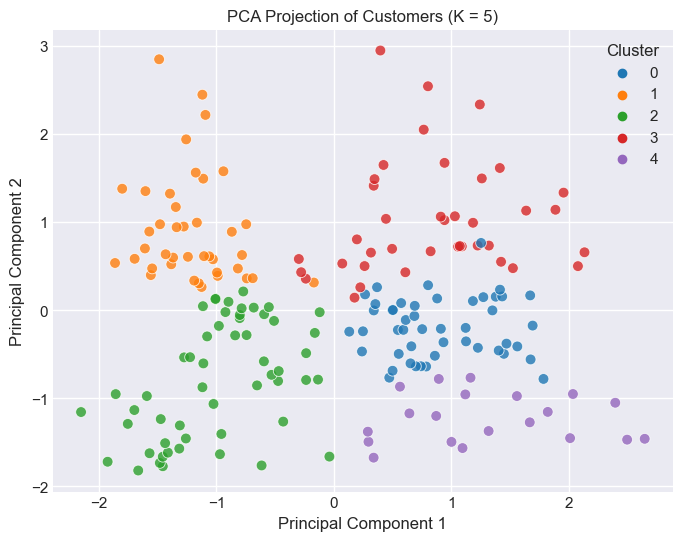

In [26]:
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Cluster"] = cluster_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="Cluster",
    palette="tab10",
    s=60,
    alpha=0.8
)
plt.title(f"PCA Projection of Customers (K = {K_FINAL})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()


### 4.1 Interpreting the PCA Plot

Each point is a customer, positioned according to a compressed summary of:

- Age
- Annual Income
- Spending Score

Clusters that appear as **well-separated groups** in the PCA plane correspond to distinct patterns in the original features. For example, one cluster may correspond to younger, high-spending customers, while another may contain older, lower-spending customers.

The exact interpretation, however, must be done in the original feature space, not the abstract PCA coordinates.


In [27]:
# Inverse-transform centroids to original feature scale for interpretation
centroids_scaled = kmeans_final.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

centroid_df = pd.DataFrame(
    centroids_original,
    columns=features
)
centroid_df["Cluster"] = range(K_FINAL)
centroid_df.set_index("Cluster", inplace=True)
centroid_df


,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,
0,55.638298,54.382979,48.851064
1,32.875000,86.100000,81.525000
2,25.185185,41.092593,62.240741
3,39.871795,86.102564,19.358974
4,46.250000,26.750000,18.350000


In [28]:
cluster_summary = df.groupby("Cluster")[features].agg(["mean", "median", "min", "max", "count"])
cluster_summary


Age                      Annual Income (k$)                  \
              mean median min max count               mean median min  max   
Cluster                                                                      
0        55.638298   54.0  40  70    47          54.382979   54.0  38   79   
1        32.875000   32.0  27  40    40          86.100000   78.5  69  137   
2        25.185185   24.0  18  38    54          41.092593   40.0  15   67   
3        39.871795   41.0  19  59    39          86.102564   78.0  64  137   
4        46.250000   47.0  20  67    20          26.750000   26.5  16   39   

              Spending Score (1-100)                       
        count                   mean median min max count  
Cluster                                                    
0          47              48.851064   48.0  35  60    47  
1          40              81.525000   83.0  58  97    40  
2          54              62.240741   58.0  39  99    54  
3          39              19.358974   17.0   1  42    39  
4          20              18.350000   14.5   3  36    20

## **5. Cluster Interpretation**

The table of centroid coordinates and per-cluster summary statistics allows us to describe each segment verbally. For example:

- **Cluster 0:** Moderate age, medium income, relatively high spending score.  
- **Cluster 1:** High income but low spending score (wealthy but not engaged).  
- **Cluster 2:** Younger customers with high spending (target group for premium offers).  
- **Cluster 3:** Older, lower income, low spending (price-sensitive group).  
- **Cluster 4:** Medium everything (baseline or "average" customers).

The exact descriptions depend on the values in your `centroid_df` and `cluster_summary` tables; they should be written carefully in the report.

The important point is that k-means has uncovered **structure** that was not annotated in the data. The segments can now be used to:

- Design differentiated marketing strategies.  
- Allocate advertising budgets more efficiently.  
- Prioritise follow-up actions for high-value groups.


## **6. Limitations and Extensions**

It is important to be honest about the limitations of this approach:

- k-means assumes **spherical clusters** of similar size in Euclidean space, which may not always be appropriate.
- The result is sensitive to rescaling and choice of features.
- The Mall Customers dataset is low-dimensional and clean; real business data are often noisier and higher-dimensional.

Possible extensions:

- Try different values of K and compare interpretability.
- Use other clustering algorithms: e.g. **Gaussian Mixture Models**, **DBSCAN**, or **Agglomerative Clustering**.
- Incorporate additional features if available (e.g. transaction history, online behaviour).
- Use **cluster labels as features** in downstream supervised models.

In the accompanying report, we can now translate these technical results into a clear narrative about **customer segmentation** and **data-driven marketing decisions**.
